# Modelling Power Load of Solar Energy
## David Schulte
## Course work: Statistical Tools in Finance and Insurance
## Prof. Dr. López Cabrera

## Imports and helper functions

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
import seaborn as sns


## Loading the data

In [3]:
header_list = ['Date', '50Hertz', 'Amprion', 'Tennet', 'Transnet BW']
for year in range(2010, 2021):
    filename = f"energy-charts_Electricity_production_in_Germany_in_{year}.csv"
    filepath = os.path.join('data', filename)
    df_current = pd.read_csv(filepath, sep=',', names=header_list, skiprows=1)
    df_current.fillna(0, inplace=True)

#     df_current["all"] = df_current["50Hertz"] + df_current["Amprion"] + df_current["Tennet"] + df_current["Transnet BW"]
        
    if year == 2010:
        df = df_current
    else:
        df = pd.concat([df, df_current])


In [4]:
df["all"] = df["50Hertz"] + df["Amprion"] + df["Tennet"] + df["Transnet BW"]
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
daily_df = df.groupby([df['Date'].dt.date]).mean()[1:]

In [7]:
daily_df

,50Hertz,Amprion,Tennet,Transnet BW,all
Date,,,,,
2010-01-01,0.004458,0.000000,0.048333,0.023208,0.076000
2010-01-02,0.004333,0.000000,0.043250,0.020833,0.068417
2010-01-03,0.002167,0.000000,0.031625,0.015167,0.048958
2010-01-04,0.001417,0.000000,0.088750,0.042667,0.132833
2010-01-05,0.002250,0.000000,0.042250,0.020333,0.064833
...,...,...,...,...,...
2020-12-27,0.246417,0.126104,0.486646,0.111229,0.970396
2020-12-28,0.281990,0.179938,0.226802,0.057177,0.745906
2020-12-29,0.258927,0.208073,0.380979,0.156646,1.004625


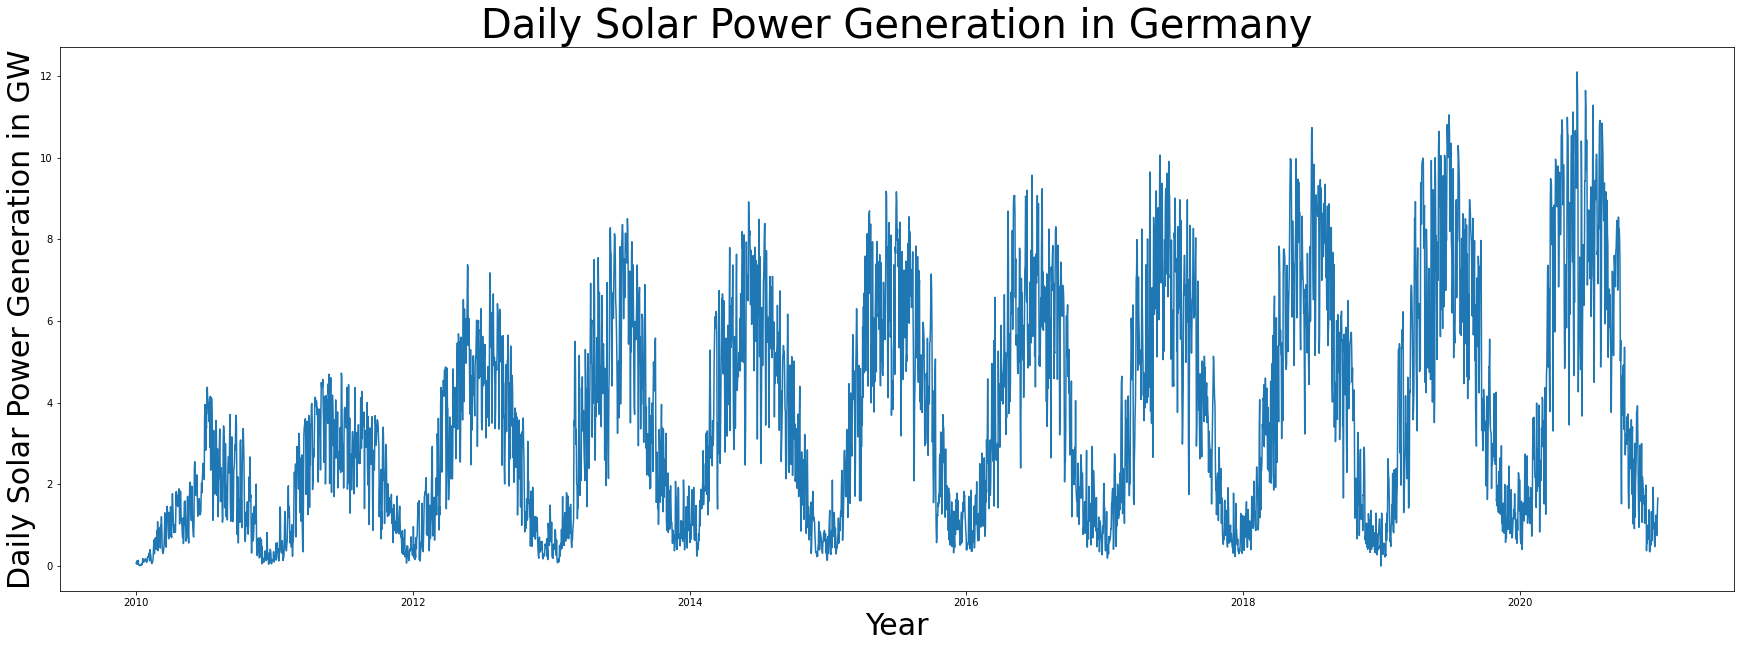

In [8]:
plt.figure(figsize=(30,10))
plt.plot(daily_df['all'])
plt.xlabel('Year', fontsize=30)
plt.ylabel('Daily Solar Power Generation in GW', fontsize=30)
plt.title('Daily Solar Power Generation in Germany', fontsize=40)
plt.savefig('data.png')

## Distribution of the data

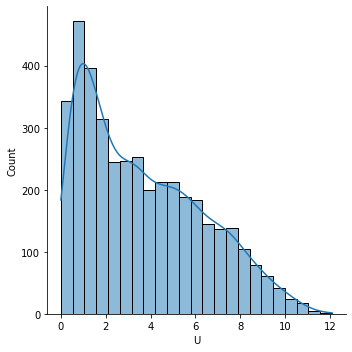

In [9]:
sns.displot(daily_df['all'], kde=True)
plt.xlabel('U')
plt.savefig('datadistr.png')

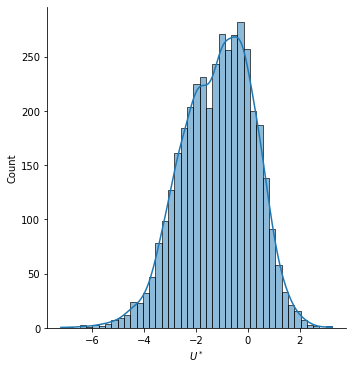

In [10]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_df['all'].to_numpy().reshape(-1, 1))
epsilon = 0.1
scaled[scaled==0]=epsilon
scaled[scaled==1]=1-epsilon
transformed = np.log(scaled/(1-scaled))
daily_df['transformed'] = transformed
sns.displot(transformed, kde=True, legend=None)
plt.xlabel('$U^*$')
plt.savefig('transformeddistr.png')

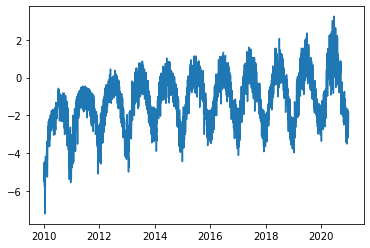

In [11]:
plt.plot(daily_df['transformed'])

## Seasonality

In [12]:
def linear(timeseries):
    time = np.arange(len(timeseries))
    x_vals = np.array((time, (time**0.25*np.cos(2*np.pi*(time+11)/365)))).T
    lm = LinearRegression().fit(x_vals, timeseries)
    print(lm.intercept_)
    print(lm.coef_)
    print('R-squared: '+str(lm.score(x_vals, timeseries)))
    return lm.predict(x_vals)


In [13]:
import statsmodels.api as sm

time = np.arange(len(transformed))
x_vals = np.array((time, (time**0.25*np.cos(2*np.pi*(time+11)/365)))).T

model = sm.OLS(transformed, sm.add_constant(x_vals))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     5272.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        11:44:14   Log-Likelihood:                -4394.5
No. Observations:                4018   AIC:                             8795.
Df Residuals:                    4015   BIC:                             8814.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0841      0.023    -91.413      0.000      -2.129      -2.039
x1             0.0005   9.83e-06     46.923      0.000       0.000       0.000
x2            -0.2282      0.002    -92.181      0.000      -0.233      -0.223
==============================================================================
Omnibus:                      507.081   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1086.897
Skew:                          -0.766   Prob(JB):                    9.62e-237
Kurtosis:                       5.036   Cond. No.                     4.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
f = open('ols.tex', 'w')
f.write(results.summary(xname=['beta0', 'beta1', 'beta2']).as_latex())
f.close()

In [15]:
modeled = linear(transformed)
daily_df['modeled'] = modeled
cleaned = transformed - modeled
daily_df['cleaned'] = cleaned

[-2.08409933]
[[ 0.00046127 -0.22820751]]
R-squared: 0.7242120048393265


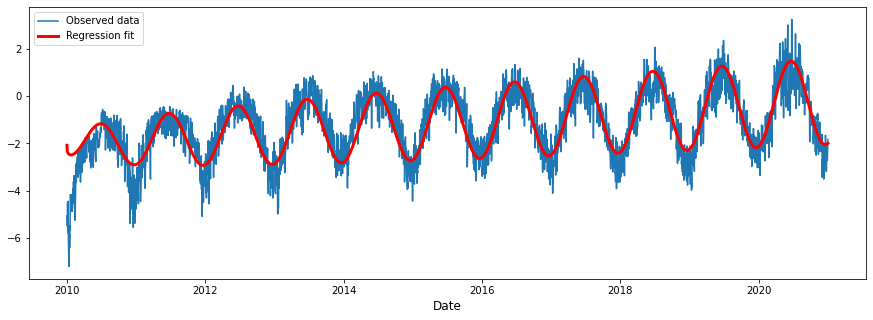

In [16]:
# plt.plot(linear(transformed))
# without_trend = daily-trend(daily)
plt.figure(figsize=(15,5))
plt.plot(daily_df['transformed'])
plt.plot(daily_df['modeled'], c='r', linewidth=3)
plt.legend(['Observed data', 'Regression fit'])
plt.xlabel('Date', fontsize=12)
plt.savefig('seasonality.png')

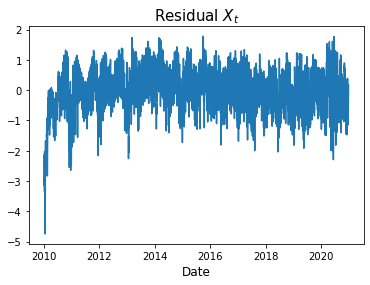

In [17]:
plt.plot(daily_df['cleaned'])
plt.title('Residual $X_t$', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.savefig('afterlm.png')

In [18]:
daily2 = daily_df[365:]
daily2

,50Hertz,Amprion,Tennet,Transnet BW,all,transformed,modeled,cleaned
Date,,,,,,,,
2011-01-01,0.011042,0.022042,0.058250,0.009917,0.101250,-4.775061,-2.895385,-1.879675
2011-01-02,0.024542,0.072958,0.090208,0.035667,0.223375,-3.973572,-2.892215,-1.081357
2011-01-03,0.022583,0.080875,0.066042,0.078875,0.248375,-3.865377,-2.888749,-0.976628
2011-01-04,0.019125,0.089500,0.067167,0.067958,0.243750,-3.884564,-2.884988,-0.999576
2011-01-05,0.051042,0.191000,0.205750,0.106500,0.554292,-3.036477,-2.880932,-0.155545
...,...,...,...,...,...,...,...,...
2020-12-27,0.246417,0.126104,0.486646,0.111229,0.970396,-2.439763,-2.027620,-0.412143
2020-12-28,0.281990,0.179938,0.226802,0.057177,0.745906,-2.722835,-2.022180,-0.700655
2020-12-29,0.258927,0.208073,0.380979,0.156646,1.004625,-2.402017,-2.016209,-0.385809


In [19]:
rmse = np.linalg.norm(daily2['cleaned'])/np.sqrt(len(daily2))
rmse

0.6583733893404919

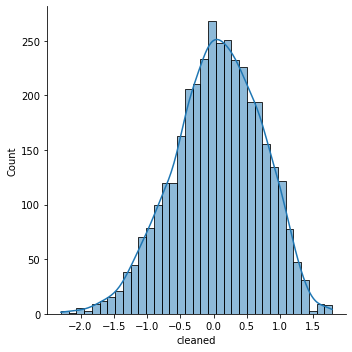

In [29]:
sns.displot(daily2['cleaned'], kde=True)

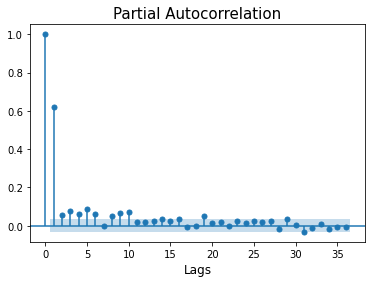

In [21]:
fig = plot_pacf(daily2['cleaned'])
plt.xlabel('Lags', fontsize=12)
plt.title('Partial Autocorrelation', fontsize=15)
plt.savefig('pacf.png')

In [22]:
model = ARIMA(daily2['cleaned'], order=(1,0,1)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [23]:
rmse = np.linalg.norm(model.resid)/np.sqrt(len(model.resid))
rmse

0.5123850785846583

In [24]:
f = open('arma.tex', 'w')
f.write(model.summary().as_latex())
f.close()

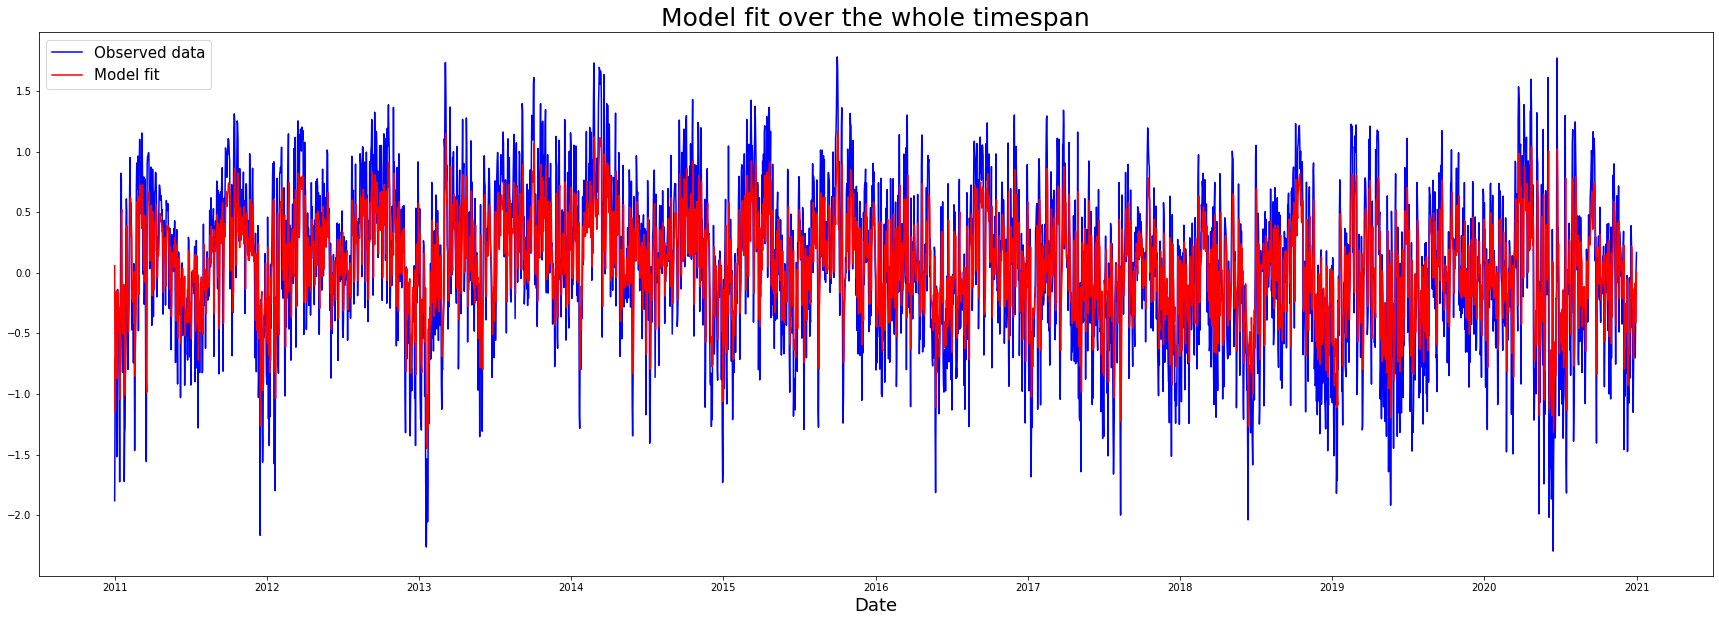

In [25]:
plt.figure(figsize=(30,10))

# plt.plot(predictions, c='g')
plt.plot(daily2['cleaned'], c='b')
plt.plot(model.fittedvalues, c='r')
plt.title('Model fit over the whole timespan', fontsize=25)
plt.xlabel('Date', fontsize=18)
plt.legend(['Observed data', 'Model fit'], fontsize=15)
plt.savefig('armafitall.png')

C:\Users\david\AppData\Local\Temp/ipykernel_47508/2238482685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily2['arma_fit'] = model.fittedvalues


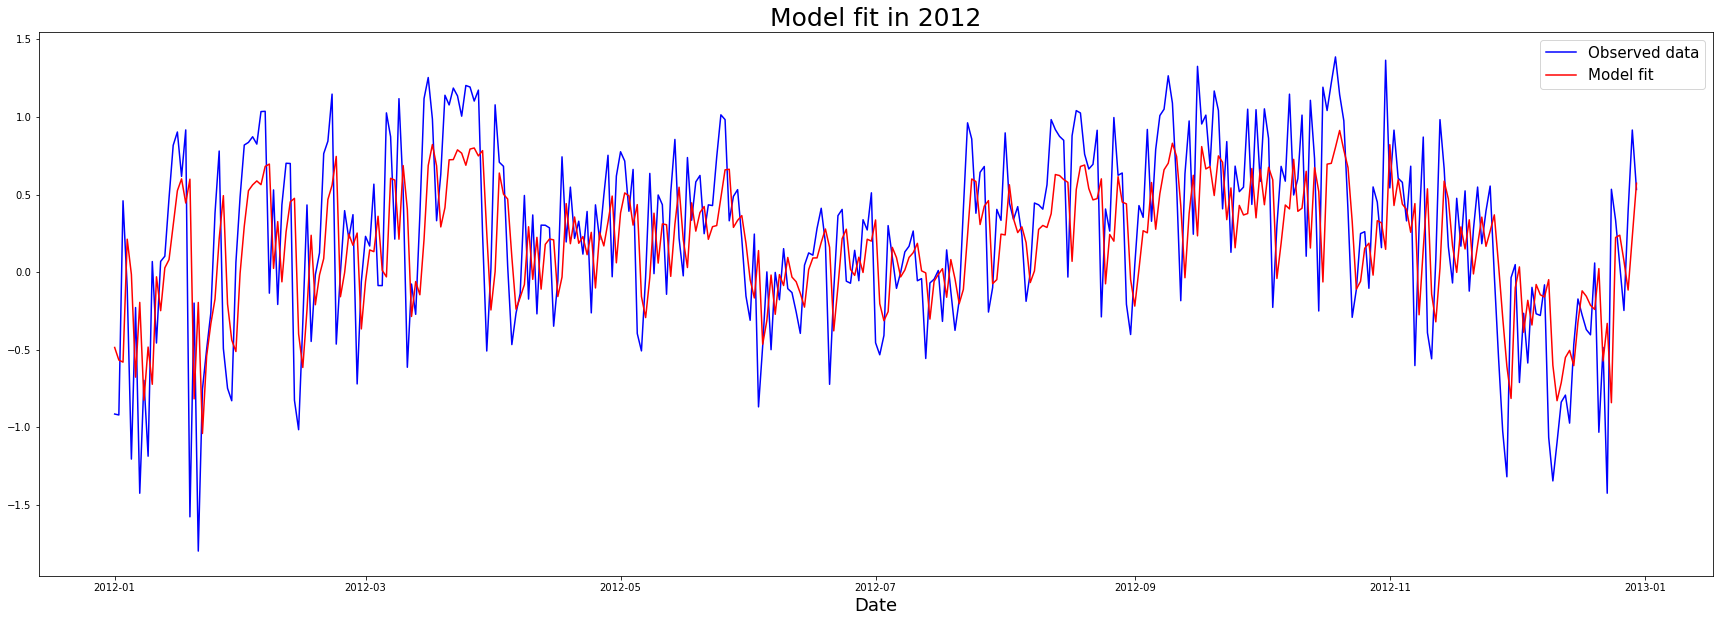

In [26]:
plt.figure(figsize=(30,10))

daily2['arma_fit'] = model.fittedvalues
# plt.plot(predictions, c='g')
plt.plot(daily2['cleaned'].iloc[365:365*2], c='b')
plt.plot(daily2['arma_fit'].iloc[365:365*2], c='r')
plt.title('Model fit in 2012', fontsize=25)
plt.xlabel('Date', fontsize=18)
plt.legend(['Observed data', 'Model fit'], fontsize=15)
plt.savefig('armafit1year.png')

In [31]:
plt.figure(figsize=(30,10))
_ = model.plot_diagnostics(figsize=(20,20))
plt.savefig('residplot.png')

In [30]:
rmse = np.linalg.norm(model.resid)/np.sqrt(len(model.resid))
rmse